# Visualize fluorescence preprocessing pipeline for whole recordings

This notebook is a step-by-step visualization of the preprocessing pipeline with output plots and explanations. The scripts `preprocess_data_SC.py` and `preprocess_data_DC.py` automate this workflow for all experiments.

In [1]:
%load_ext autoreload
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from ipywidgets import interact
import ipywidgets as widgets

import paths
import functions_preprocessing as fpp
import functions_io as f_io
import functions_plotting as fp
from functions_utils import find_zone_and_behavior_episodes, add_episode_data

f_io.check_dir_exists(paths.figure_directory)

ModuleNotFoundError: No module named 'ipympl'

## Load the data

For convenience, load the already preprocesed data. This dataset contains the columns 'gcamp' and 'auto', which are the raw data

In [2]:
mouse = 1
day = 3

data_df = f_io.load_preprocessed_data(mouse, day)

In [3]:
data_df.head()

,time,gcamp,auto,animal,day,dff,zscore,behavior,zone,Ear Scratch,...,Idle,Shock,Social Interaction,Squeezed MZ Edge,Switch,Transfer,WSW,Eating Zone,Marble Zone,Nesting Zone
0,0.085969,0.647619,2.995199,1,3,-78.378112,-2.513977,,,,...,,,,,,,,,,
1,0.110578,0.646681,2.984903,1,3,-78.334937,-2.436197,,,,...,,,,,,,,,,
2,0.135187,0.645720,2.975260,1,3,-78.297016,-2.367884,,,,...,,,,,,,,,,
3,0.159797,0.644736,2.966269,1,3,-78.264427,-2.309175,,,,...,,,,,,,,,,
4,0.184406,0.643727,2.957930,1,3,-78.237239,-2.260196,,,,...,,,,,,,,,,


## Visualize raw traces

Here we notice some disconinuities and jumps in the data set. We need to figure out what to do with them to clean this up.

In [13]:
def plot_two_traces(time, trace1, trace2):    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(9,6))
    
    axes[0] = fp.plot_fluorescence_min_sec(time, trace1, ax=axes[0])
    axes[0].set_ylabel('Fluorescence (AU)')
    
    axes[1] = fp.plot_fluorescence_min_sec(time, trace2, ax=axes[1])
    axes[1].set_ylabel('Fluorescence (AU)')
    axes[1].set_xlabel('Time')
    
    return fig, axes

<IPython.core.display.Javascript object>


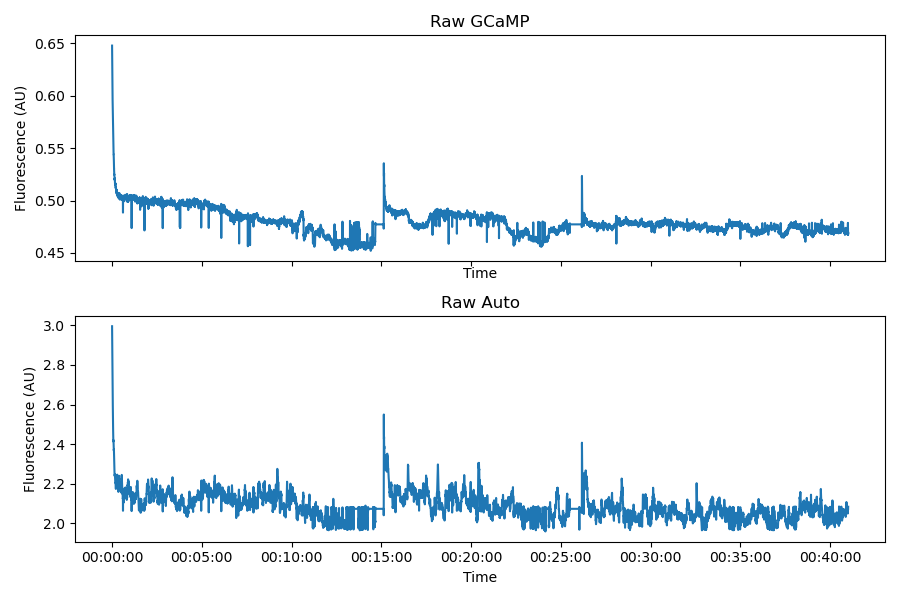

In [14]:
fig, axes = plot_two_traces(data_df.time, data_df.gcamp, data_df.auto)
axes[0].set_title('Raw GCaMP')
axes[1].set_title('Raw Auto')
plt.tight_layout()

## Remove NaNs

These traces have some NaNs in them. This affects later processing. The function `fpp.remove_nans` finds these values and removes them by interpolating.

In [15]:
gcamp = data_df.gcamp.to_numpy()
gcamp = fpp.remove_nans(gcamp)

auto = data_df.auto.to_numpy()
auto = fpp.remove_nans(auto)

<IPython.core.display.Javascript object>


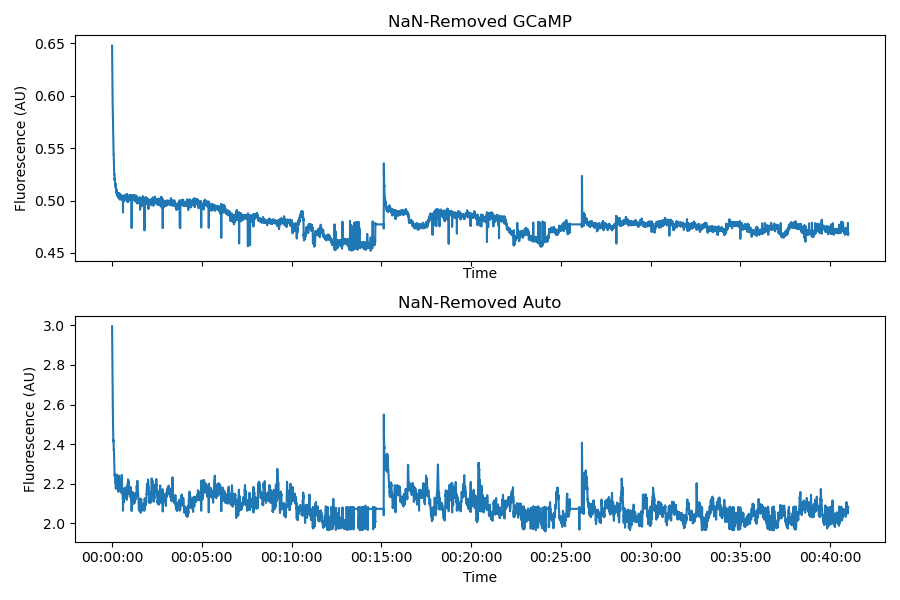

In [16]:
fig, axes = plot_two_traces(data_df.time, gcamp, auto)
axes[0].set_title('NaN-Removed GCaMP')
axes[1].set_title('NaN-Removed Auto')
plt.tight_layout()

# Find periods where the signal is lost

Notice that sometimes the signal is lost, and a flat line is found in the data. Remove this section and replace it with NaNs. I know we just removes NaNs earlier, but these are large gaps which should be ignored for the analysis.

We identify these sections by calculating the derivative of both channels. Where the derivative is zero, the signal is flat and presumably lost. Find where this occurs in both signals, and replace with np.NaN

In [10]:
d_gcamp = np.r_[0, np.abs(np.diff(gcamp))]
d_auto = np.r_[0, np.abs(np.diff(auto))]
gcamp_d0 = np.where(d_gcamp == 0)[0]
auto_d0 = np.where(d_auto == 0)[0]
shared_zero = np.unique(np.concatenate((gcamp_d0, auto_d0)))

In [11]:
# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
# axes[0][0].plot(data_df.time, gcamp)
# axes[1][0].plot(data_df.time, d_gcamp)
# axes[0][1].plot(data_df.time, auto, c='orange')
# axes[1][1].plot(data_df.time, d_auto, c='orange')

In [13]:
# fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
# axes[0].plot(data_df.time, gcamp)
# axes[1].plot(data_df.time, auto, c='orange')

# High pass filter to remove the decay

Notice that there is a decay throughout the experiment. High pass filter (>0.1 Hz) to remove this.

In [17]:
import scipy.signal as sig

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    high_cut = cutoff / nyq
    b, a = sig.butter(order, high_cut, btype='highpass')
    return b, a

In [18]:
fs = 40    # Hz
cutoff = 0.05 # Hz

b, a = butter_highpass(cutoff, fs)
gcamp_hpf = sig.filtfilt(b, a, gcamp)
auto_hpf = sig.filtfilt(b, a, auto)

<IPython.core.display.Javascript object>


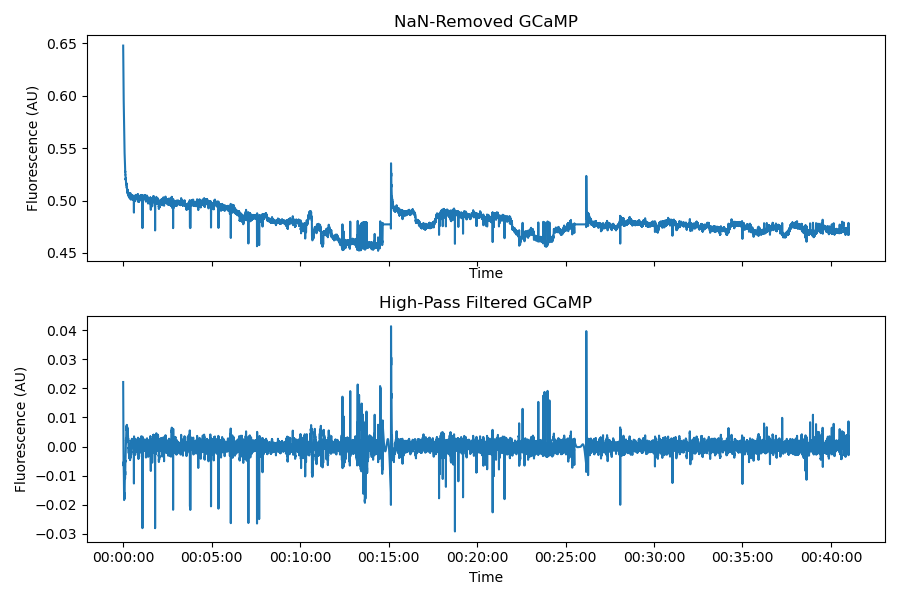

In [20]:
fig, axes = plot_two_traces(data_df.time, gcamp, gcamp_hpf)
axes[0].set_title('NaN-Removed GCaMP')
axes[1].set_title('High-Pass Filtered GCaMP')
plt.tight_layout()

# Low pass filter to remove noise artifacts

Notice that there is some jitter still in the plot. Low pass filter the data with a frequency that makes sense for the Ca2+ indicator. If GCaMP6s, this is ~10 Hz.

In [21]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    low_cut = cutoff / nyq
    b, a = sig.butter(order, low_cut, btype='lowpass')
    return b, a

In [23]:
fs = 40    # Hz
cutoff = 19 # Hz

b, a = butter_lowpass(cutoff, fs)
gcamp_lpf = sig.filtfilt(b, a, gcamp_hpf)
auto_lpf = sig.filtfilt(b, a, auto_hpf)

<IPython.core.display.Javascript object>


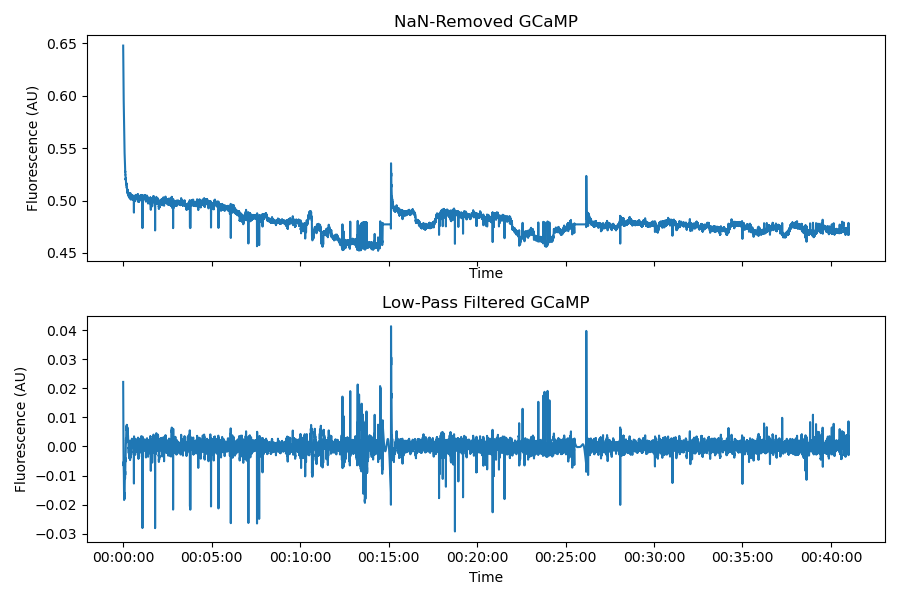

In [24]:
fig, axes = plot_two_traces(data_df.time, gcamp, gcamp_lpf)
axes[0].set_title('NaN-Removed GCaMP')
axes[1].set_title('Low-Pass Filtered GCaMP')
plt.tight_layout()

# Apply SavGol filter for smoothing

In [48]:
auto_savgol = savgol_filter(auto_lpf, 5, 2)
gcamp_savgol = savgol_filter(gcamp_lpf, 5, 2)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(data_df.time, gcamp_savgol)
ax2.plot(data_df.time, auto_savgol, c='orange')

# Remove periods where signal is lost

This has to be applied after filtering, because the filters can't handle NaNs

In [33]:
gcamp_lps[shared_zero] = np.NaN
auto_lps[shared_zero] = np.NaN

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(data_df.time, gcamp_lps)
axes[1].plot(data_df.time, auto_lps, c='orange')

# Remove movement artifacts

Let's take the derivative of the traces and see what's going on with the jumps.

In [18]:
d_gcamp = np.r_[0, np.abs(np.diff(gcamp))]
d_auto = np.r_[0, np.abs(np.diff(auto))]

In [21]:
mean_d_gcamp = np.mean(d_gcamp)
mean_d_auto = np.mean(d_auto)
std_d_gcamp = np.std(d_gcamp)
std_d_auto = np.std(d_auto)

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
axes[0][0].plot(data_df.time, gcamp)
axes[1][0].axhline(mean_d_gcamp)
axes[1][0].axhline(2*std_d_gcamp, color='r')
axes[1][0].plot(data_df.time, d_gcamp)
axes[0][1].plot(data_df.time, auto, c='orange')
axes[1][1].plot(data_df.time, d_auto, c='orange')
axes[1][1].axhline(mean_d_auto)
axes[1][1].axhline(2*std_d_auto, color='r')

We see that where there are large abnormalities in the traces, the derivative has sharp increases. We can arbitrarily select a cutoff and use that to find points that we want to interpolate. Let's choose to work with the autofluorescence trace, since it isn't activity-dependent.

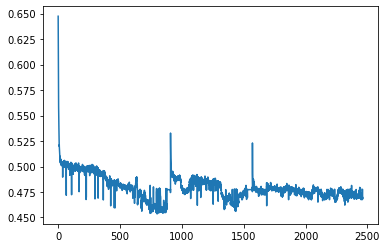

In [45]:
gcamp_jumps = np.where(d_gcamp >= 0.002)[0]
g_camp_rem_jumps = gcamp_smooth.copy()
g_camp_rem_jumps[gcamp_jumps] = np.interp(np.flatnonzero(gcamp_jumps), np.flatnonzero(~gcamp_jumps), g_camp_rem_jumps[~gcamp_jumps])

plt.plot(data_df.time, g_camp_rem_jumps)

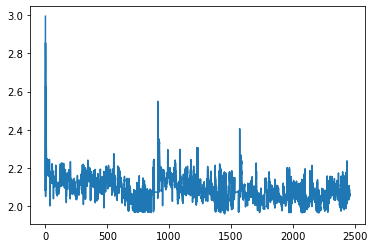

In [23]:
auto_jumps = np.where(d_auto >= 0.005)[0]
auto[auto_jumps] = np.interp(np.flatnonzero(auto_jumps), np.flatnonzero(~auto_jumps), auto[~auto_jumps])

plt.plot(data_df.time, auto)

In [ ]:
# Places where the derivative is 0 are questionable and should be removed or marked somehow
d_gcamp = np.r_[0, np.abs(gcamp[1:] - gcamp[:-1])]
d_zero = np.where(d1 == 0)[0]
gcamp_interp = gcamp.copy()
# gcamp_interp[d_zero] = np.NaN

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(data_df.gcamp)
ax2.plot(gcamp_interp)

# Smooth the data

Use a Savgol filter to smooth out the data

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x7ffa1f6c81d0>])

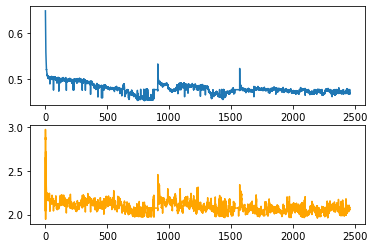

In [41]:
kernel = 21
order = 3

auto_smooth = savgol_filter(auto, kernel, order)
gcamp_smooth = savgol_filter(gcamp, kernel, order)

plt.subplot(2, 1, 1), plt.plot(data_df.time, gcamp_smooth)
plt.subplot(2, 1, 2), plt.plot(data_df.time, auto_smooth, c='orange')

In [49]:
1/40

0.025